<a href="https://colab.research.google.com/github/ixcheldelsun/ImageCaptioning_COCOdataset/blob/master/Image_captioning_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning
Para la construcción del modelo se hizo referencia a las siguientes páginas:
https://www.tensorflow.org/tutorials/text/image_captioning y
https://medium.com/datadriveninvestor/attention-mechanism-image-captioning-using-tensorflow-ebf180ec67ec. Se hicieron cambios al encoder del modelo, mas se mantuvo la arquitectura en el decoder y en el attention-model, ya que se inspiraron en la arquitectura encontrada en el siguiente link para la construcción del mismo https://arxiv.org/pdf/1502.03044.pdf.

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 
import re
import numpy as np
import os
import time 
import json 
from glob import glob 
from PIL import Image
import pickle 
from tqdm import tqdm

### Descarga del dataset

In [4]:
# Download caption annotation files 
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder): 
  annotation_zip = tf.keras.utils.get_file('captions.zip', cache_subdir = os.path.abspath('.'), origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip', extract=True)
  annotation_file = os.path.dirname(annotation_zip) + '/annotations/captions_train2014.json'
  os.remove(annotation_zip)

252878848/252872794 [==============================] - 8s 0us/step


In [5]:
# Download image files 
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder): 
  image_zip = tf.keras.utils.get_file('train2014.zip', cache_subdir=os.path.abspath('.'), origin = 'http://images.cocodataset.org/zips/train2014.zip', extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else: 
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 374s 0us/step


In [6]:
with open(annotation_file, 'r') as f: 
  annotations = json.load(f)

all_captions = []
all_img_name_vector = []

for annotation in annotations['annotations']: 
  caption = '<start>' + annotation['caption'] + '<end>'
  image_id = annotation['image_id']
  full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)

train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state = 1)

num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

### Preprocesamiento de las imágenes

En esta sección se implementa un modelo pre-entrenado con las imágenes de Imagenet llamdo InceptionV3 para entrenarlo con las imágenes obtenidas del COCO dataset, obtener los pesos resultantes e implementarlos en nuestro modelo (transfer learning).

In [7]:
def load_image(image_path): 
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  return img, image_path

**Initialize InceptionV3 and load the pretrained Imagenet weights**

In [8]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


In [9]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset): 
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, 
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode('utf-8')
    np.save(path_of_feature, bf.numpy())


100%|██████████| 1622/1622 [05:33<00:00,  4.87it/s]


## Tokenización de los captions

Para el procesamiento de los captions de las imágenes, se implementa un tokenizer tal que podamos mapear un caracter con un indice (de valor escalar) y asi poder ser usados como parte del input del modelo en su entrenamiento. 

In [10]:
def calc_max_length(tensor): 
  return max(len(t) for t in tensor)

In [11]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k, oov_token = '<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [12]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [13]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [14]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding = 'post')

In [15]:
max_length = calc_max_length(train_seqs)

## División de la data de entrenamiento y la data de testing

In [16]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector, test_size = 0.2, random_state = 0)

In [17]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Creación del dataset del training

In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256 
units = 512 
vocab_size = top_k + 1
num_steps = len(img_name_train)

features_shape = 2048 
attention_features_shape = 64

In [19]:
def map_func(img_name, cap): 
  img_tensor = np.load(img_name.decode('utf-8') + '.npy')
  return img_tensor, cap 

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]), 
          num_parallel_calls = tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

## Creación del modelo 

In [21]:
class BahdanauAttention(tf.keras.Model): 
  def __init__(self, units): 
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden): 
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    context_vector = attention_weights * features 
    context_vector = tf.reduce_sum(context_vector, axis = 1)

    return context_vector, attention_weights 

In [33]:
class CNN_Encoder(tf.keras.Model): 
  def __init__(self, embedding_dim): 
    super(CNN_Encoder, self).__init__()
    self.fc = tf.keras.layers.Dense(embedding_dim)

  def call(self, x): 
    x = self.fc(x)
    x = tf.nn.leaky_relu(x)
    return x

In [34]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size): 
    super(RNN_Decoder, self).__init__()
    self.units = units 

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden): 
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)

    output, state = self.gru(x)

    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights 

  def reset_state(self, batch_size): 
    return tf.zeros((batch_size, self.units))

In [35]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [36]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred): 
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask 

  return tf.reduce_mean(loss_)

## Checkpoint 

In [37]:
checkpoint_path = './checkpoint/train'
ckpt = tf.train.Checkpoint(encoder = encoder, decoder = decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 5)

In [38]:
start_epoch = 0

if ckpt_manager.latest_checkpoint: 
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Entrenamiento del modelo

Se entrena el modelo tomando en cuenta que se implementó lo siguiente: 
- loss: sparse categorical cros-entropy. 
- tamaño del batch: 64 ejemplos de entrenamiento (training samples). 
- optimizador: adam.
- número de epochs: 20. 

In [39]:
loss_plot = []

In [40]:
@tf.function
def train_step(img_tensor, target): 
  loss = 0

  hidden = decoder.reset_state(batch_size = target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape: 
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]): 
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      loss += loss_function(target[:, i], predictions)

      dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss 

In [42]:
EPOCHS = 20
total_loss = 0
loss = 0 

for epoch in range(start_epoch, EPOCHS): 
  start = time.time()
  

  for (batch, (img_tensor, target)) in enumerate(dataset): 
    batch_loss, t_loss = train_step(img_tensor, target)
    total_loss += t_loss

    if batch % 100 == 0: 
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

  loss_plot.append(total_loss / num_steps)

  if epoch % 5 == 0: 
    ckpt_manager.save()

  print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.8400
Epoch 1 Batch 100 Loss 1.1467
Epoch 1 Batch 200 Loss 0.9512
Epoch 1 Batch 300 Loss 0.9949
Epoch 1 Loss 0.015880
Time taken for 1 epoch 319.7563738822937 sec

Epoch 2 Batch 0 Loss 0.7961
Epoch 2 Batch 100 Loss 0.8283
Epoch 2 Batch 200 Loss 0.7427
Epoch 2 Batch 300 Loss 0.7980
Epoch 2 Loss 0.028274
Time taken for 1 epoch 353.8687164783478 sec

Epoch 3 Batch 0 Loss 0.7344
Epoch 3 Batch 100 Loss 0.7416
Epoch 3 Batch 200 Loss 0.7273
Epoch 3 Batch 300 Loss 0.6894
Epoch 3 Loss 0.039564
Time taken for 1 epoch 351.1776270866394 sec

Epoch 4 Batch 0 Loss 0.7133
Epoch 4 Batch 100 Loss 0.6653
Epoch 4 Batch 200 Loss 0.6905
Epoch 4 Batch 300 Loss 0.7003
Epoch 4 Loss 0.050132
Time taken for 1 epoch 349.25722074508667 sec

Epoch 5 Batch 0 Loss 0.6693
Epoch 5 Batch 100 Loss 0.6914
Epoch 5 Batch 200 Loss 0.7318
Epoch 5 Batch 300 Loss 0.6261
Epoch 5 Loss 0.060105
Time taken for 1 epoch 349.78274297714233 sec

Epoch 6 Batch 0 Loss 0.6308
Epoch 6 Batch 100 Loss 0.6318
Epoch 6 Ba

In [43]:
print("Mean loss: {}".format(tf.math.reduce_mean(loss_plot)))

Mean loss: 0.09647561609745026


# Evaluación del modelo

In [44]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [45]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start>the two people on the park bench care for one another <end>
Prediction Caption: man lying together on a metal bench with flowers in the <unk> park <end>


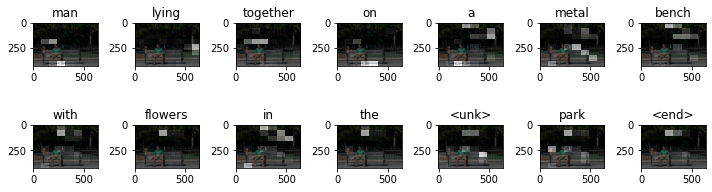

In [46]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [47]:
# Download image files 
evaluation_folder = '/evaluate2017/'
if not os.path.exists(os.path.abspath('.') + evaluation_folder): 
  image_zip = tf.keras.utils.get_file('val2017.zip', cache_subdir=os.path.abspath('.'), origin = 'http://images.cocodataset.org/zips/val2017.zip', extract=True)
  PATH = os.path.dirname(image_zip) + evaluation_folder
  os.remove(image_zip)
else: 
  PATH = os.path.abspath('.') + evaluation_folder

815587328/815585330 [==============================] - 23s 0us/step


In [48]:
def loadImages(path):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
    image_files = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    return image_files

In [49]:
evaluation_images = loadImages('/content/val2017')

In [50]:
evaluation_images

['/content/val2017/000000000139.jpg',
 '/content/val2017/000000000285.jpg',
 '/content/val2017/000000000632.jpg',
 '/content/val2017/000000000724.jpg',
 '/content/val2017/000000000776.jpg',
 '/content/val2017/000000000785.jpg',
 '/content/val2017/000000000802.jpg',
 '/content/val2017/000000000872.jpg',
 '/content/val2017/000000000885.jpg',
 '/content/val2017/000000001000.jpg',
 '/content/val2017/000000001268.jpg',
 '/content/val2017/000000001296.jpg',
 '/content/val2017/000000001353.jpg',
 '/content/val2017/000000001425.jpg',
 '/content/val2017/000000001490.jpg',
 '/content/val2017/000000001503.jpg',
 '/content/val2017/000000001532.jpg',
 '/content/val2017/000000001584.jpg',
 '/content/val2017/000000001675.jpg',
 '/content/val2017/000000001761.jpg',
 '/content/val2017/000000001818.jpg',
 '/content/val2017/000000001993.jpg',
 '/content/val2017/000000002006.jpg',
 '/content/val2017/000000002149.jpg',
 '/content/val2017/000000002153.jpg',
 '/content/val2017/000000002157.jpg',
 '/content/v

In [70]:
caption_number = [i for i in range(len(evaluation_images))]
caption_number

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [71]:
evaluation_captions = []

for image in evaluation_images:
  result, attention_plot = evaluate(image)
  evaluation_captions.append(result)
  print ('Prediction Caption:', ' '.join(result))
  # opening the image
  #Image.open(image_path)

evaluation_captions

Streaming output truncated to the last 5000 lines.
Prediction Caption: woman sitting on a long hair listening to the water <end>
Prediction Caption: little girl talking on the camera as he with a donut in front of a donut in the camera <end>
Prediction Caption: young woman lays down wii in an empty room <end>
Prediction Caption: small entree is sitting on a placemat <end>
Prediction Caption: man is pulled into a surfboard <end>
Prediction Caption: computer sits on a desk cluttered desk <end>
Prediction Caption: city street signs indicated of a city intersection <end>
Prediction Caption: large pink double decker bus near some city street <end>
Prediction Caption: black and white cat behind a nap <end>
Prediction Caption: jet is flying over the sky <end>
Prediction Caption: person is standing near each other <end>
Prediction Caption: alone in an empty living room <end>
Prediction Caption: city bus sitting on a motorcycle in front of the street<end> <end>
Prediction Caption: apple and one

[['couple',
  'of',
  'black',
  'double',
  'decker',
  'room',
  'with',
  'a',
  'glass',
  'living',
  'room',
  'area',
  '<end>'],
 ['brown',
  'brown',
  'bear',
  '<unk>',
  'near',
  'some',
  'rocks',
  'and',
  'a',
  'chain',
  'looking',
  'looking',
  'with',
  'a',
  'blue',
  'fence',
  '<end>'],
 ['bed',
  'room',
  'with',
  'a',
  'room',
  'with',
  'a',
  'sleeping',
  'on',
  'the',
  'plant',
  '<end>'],
 ['stop', 'sign', 'made', 'way', 'way', 'with', 'a', 'street', 'end', '<end>'],
 ['teddy',
  'bears',
  'that',
  'is',
  'near',
  'an',
  'shirt',
  'next',
  'back',
  'positioned',
  'wearing',
  'an',
  'tray',
  'hugging',
  'next',
  'to',
  'a',
  'tray',
  'holding',
  'its',
  'covers',
  'lying',
  'asleep',
  'lying',
  'below',
  'an',
  'dolls',
  'in',
  'another',
  'child',
  'in',
  'a',
  'tray',
  'holding',
  'smiling',
  'face<end>',
  'wearing',
  'brown',
  'bear',
  'toys',
  'covers',
  'another',
  'jeans',
  'hugging',
  'near',
  'an'

In [72]:
evaluation_captions = zip(caption_number, evaluation_captions)

In [73]:
evaluation_captions = list(evaluation_captions)
evaluation_captions

[(0,
  ['couple',
   'of',
   'black',
   'double',
   'decker',
   'room',
   'with',
   'a',
   'glass',
   'living',
   'room',
   'area',
   '<end>']),
 (1,
  ['brown',
   'brown',
   'bear',
   '<unk>',
   'near',
   'some',
   'rocks',
   'and',
   'a',
   'chain',
   'looking',
   'looking',
   'with',
   'a',
   'blue',
   'fence',
   '<end>']),
 (2,
  ['bed',
   'room',
   'with',
   'a',
   'room',
   'with',
   'a',
   'sleeping',
   'on',
   'the',
   'plant',
   '<end>']),
 (3,
  ['stop',
   'sign',
   'made',
   'way',
   'way',
   'with',
   'a',
   'street',
   'end',
   '<end>']),
 (4,
  ['teddy',
   'bears',
   'that',
   'is',
   'near',
   'an',
   'shirt',
   'next',
   'back',
   'positioned',
   'wearing',
   'an',
   'tray',
   'hugging',
   'next',
   'to',
   'a',
   'tray',
   'holding',
   'its',
   'covers',
   'lying',
   'asleep',
   'lying',
   'below',
   'an',
   'dolls',
   'in',
   'another',
   'child',
   'in',
   'a',
   'tray',
   'holding',
   '

In [74]:
np.savetxt('image_captioning.csv', evaluation_captions, fmt = '% s')